## LOADING THE DATASET

In [15]:
from keras.datasets import mnist
import numpy as np

(trainImages, _), (testImages, _) = mnist.load_data()

trainImages, testImages = trainImages / 255.0, testImages / 255.0

#print("Training dimensions:", trainImages.shape)
#print("Test dimensions:", testImages.shape)

flattenedTrainImages = trainImages.reshape((trainImages.shape[0], -1))
flattenedTestImages = testImages.reshape((testImages.shape[0], -1))

print("Flattened training dimensions:", flattenedTrainImages.shape)
print("Flattened test dimensions:", flattenedTestImages.shape)

np.random.seed(42)      #To ensure that same images are used across pca and ppca. Change seed value for different images
selectedImages = np.random.choice(len(testImages), size = 5, replace=False)

Flattened training dimensions: (60000, 784)
Flattened test dimensions: (10000, 784)


## PCA IMPLEMENTATION

MSE for latent dimension 2 is: 0.05566949193442309


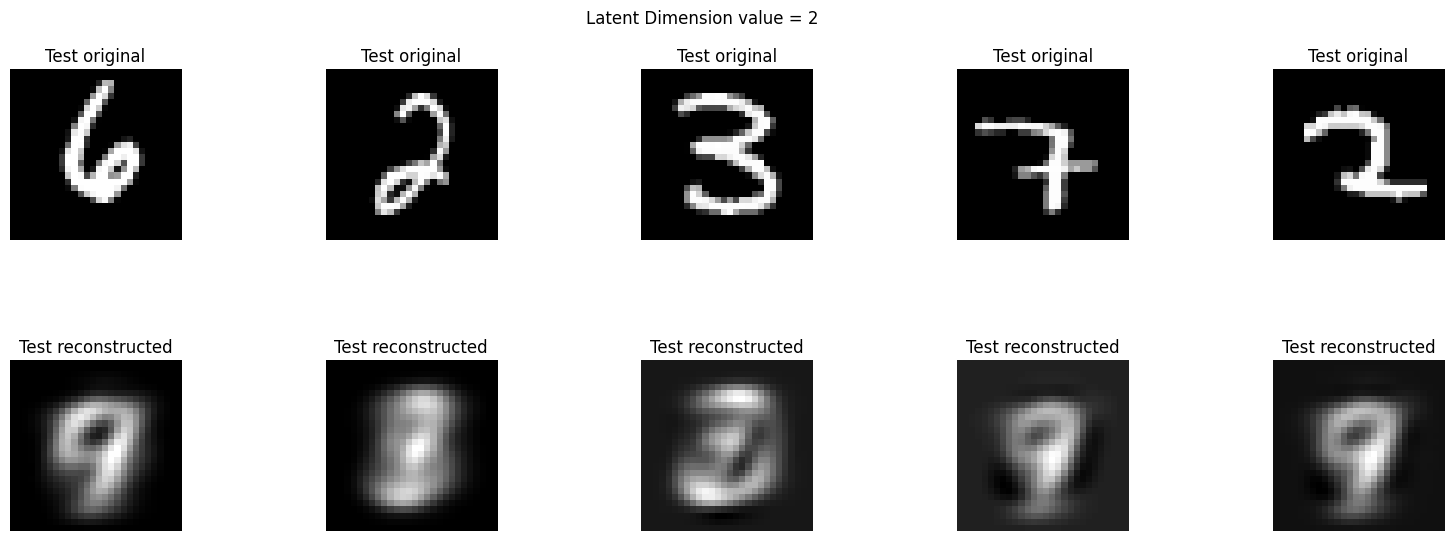

MSE for latent dimension 4 is: 0.04790346506558457


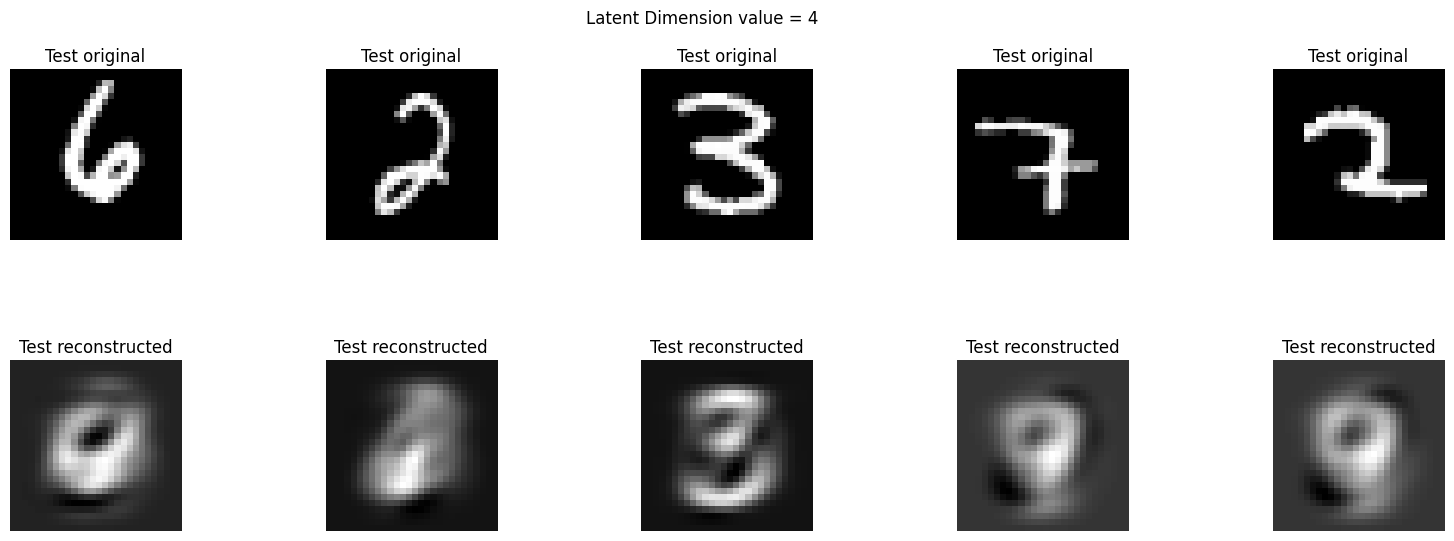

MSE for latent dimension 8 is: 0.037440933919030965


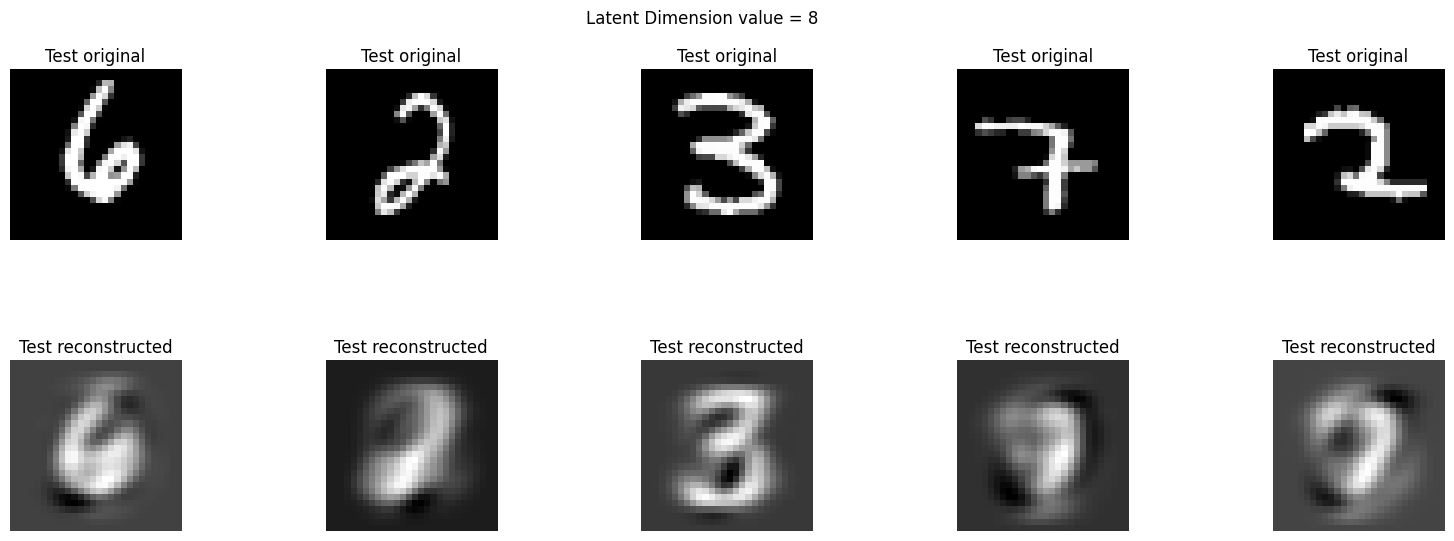

MSE for latent dimension 16 is: 0.02686019078827122


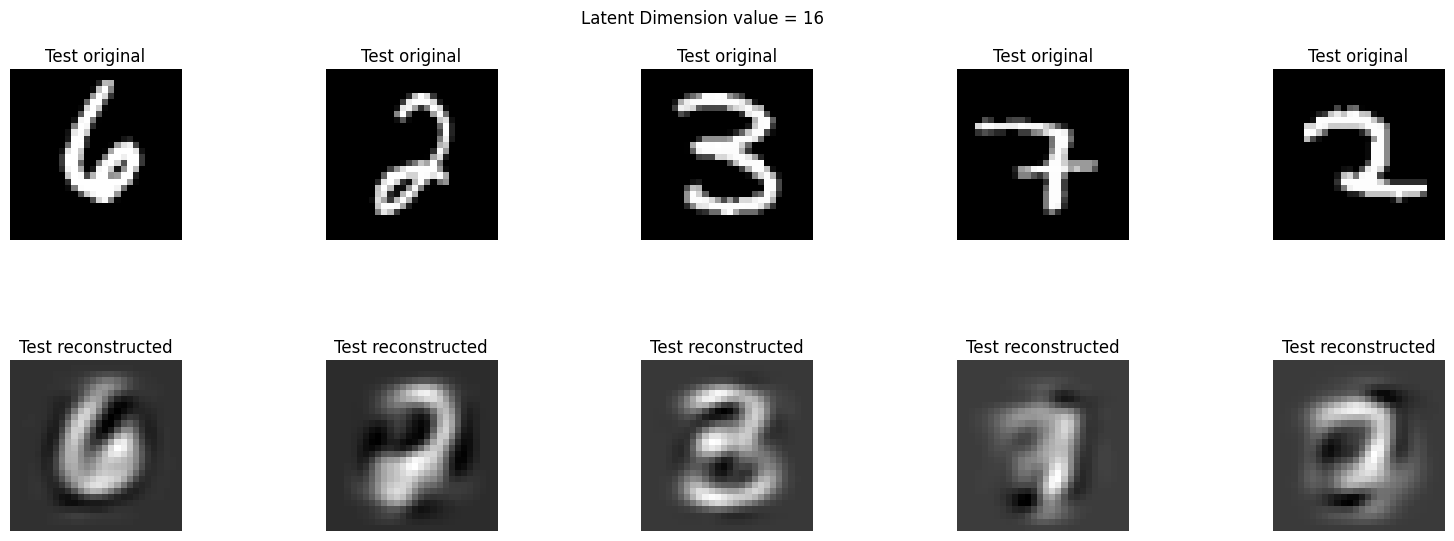

MSE for latent dimension 32 is: 0.016829987691859553


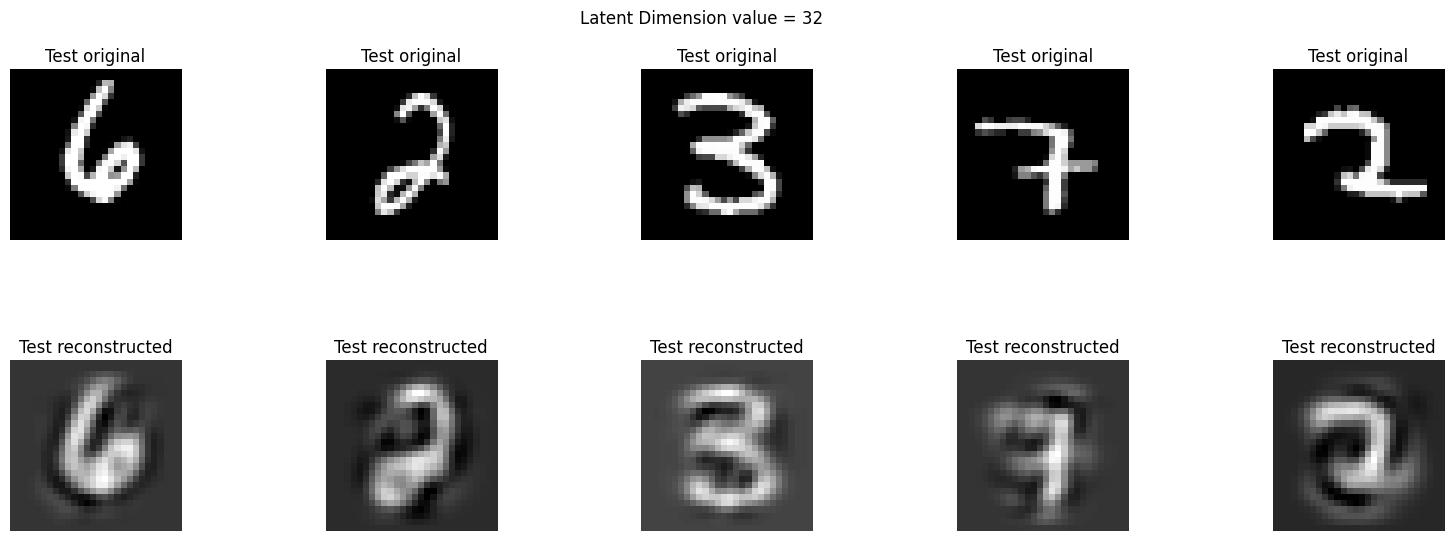

MSE for latent dimension 64 is: 0.009047770446754689


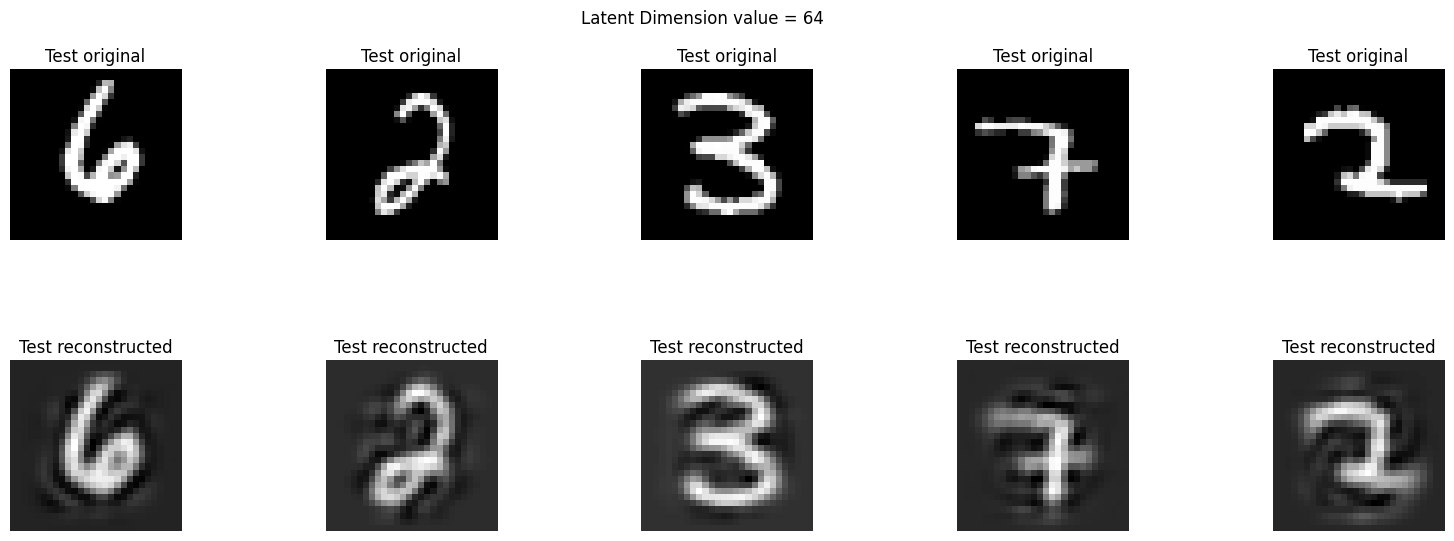

In [16]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

latentDimensions = [2, 4, 8, 16, 32, 64] 

def pcaFn(latentDimensionValue, flattenedTestImages):
    pca = PCA(n_components=latentDimensionValue)
    pca.fit(flattenedTrainImages)

    transformedImages = pca.inverse_transform(pca.transform(flattenedTestImages))
    transformedImages = transformedImages.reshape((-1, 28 * 28))    #Converting into 2d array

    return transformedImages

def pcaMSE(originalImages, reconstructedImages):
    return np.mean((originalImages - reconstructedImages)**2)

pca_mse_values_list = []

for latentDimensionValue in latentDimensions:

    reconstructedImages = pcaFn(latentDimensionValue, flattenedTestImages)
    mseVal = pcaMSE(flattenedTestImages,reconstructedImages)
    pca_mse_values_list.append(mseVal)

    print("MSE for latent dimension {} is: {}".format(latentDimensionValue,mseVal))

    plt.figure(figsize=(20,6))
    plt.suptitle(f"Latent Dimension value = {latentDimensionValue}")

    for i, idx in enumerate(selectedImages):
        plt.subplot(2, 5, i + 1)
        plt.imshow(testImages[idx], cmap='gray')
        plt.title(f"Test original")
        plt.axis('off') #Removes x and y axis labels

        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructedImages[idx].reshape(28,28), cmap='gray')    #reshaping the 1d array back to 2d for accessing
        plt.title(f"Test reconstructed")
        plt.axis('off')

    plt.subplots_adjust(hspace=0.7, wspace=0.1)
    plt.show()



## PROBABILISTIC PCA IMPLEMENTATION

MSE val for latent dimension 2 is 0.055616065817805635


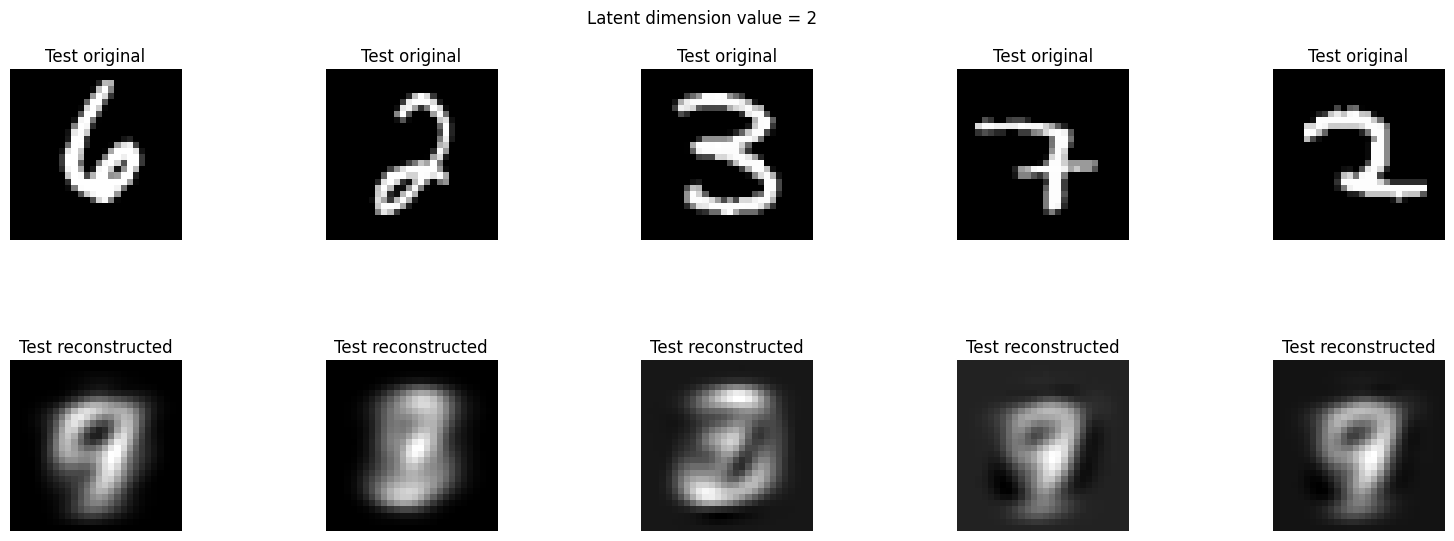

MSE val for latent dimension 4 is 0.04785867676369214


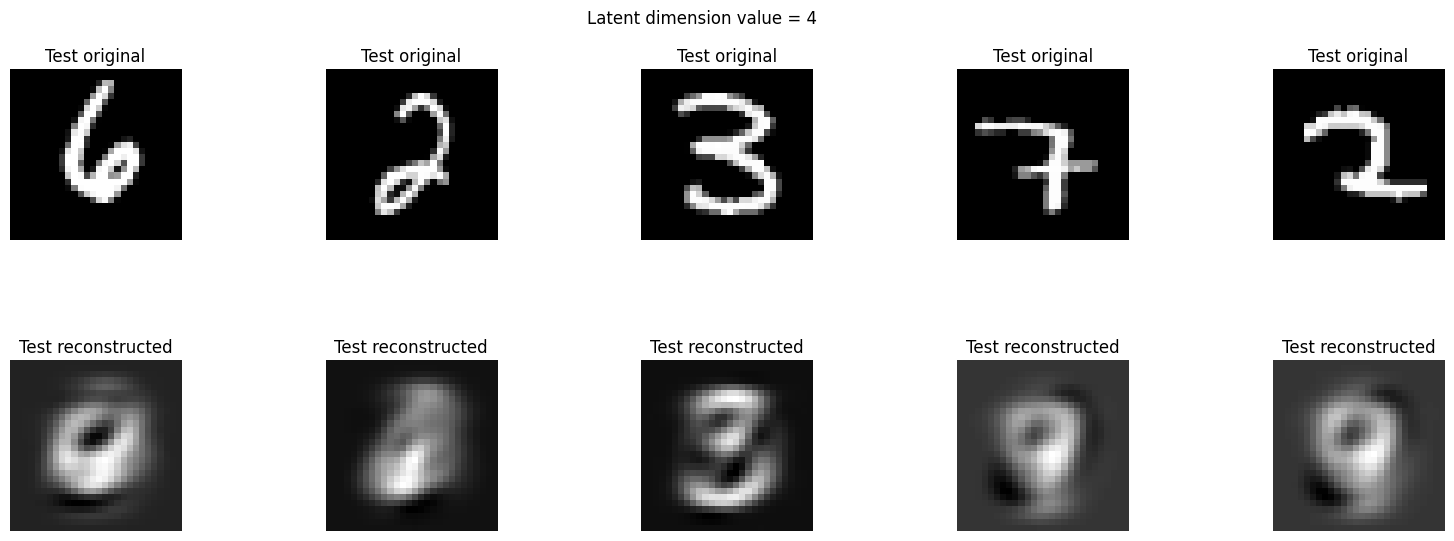

MSE val for latent dimension 8 is 0.037419426603041844


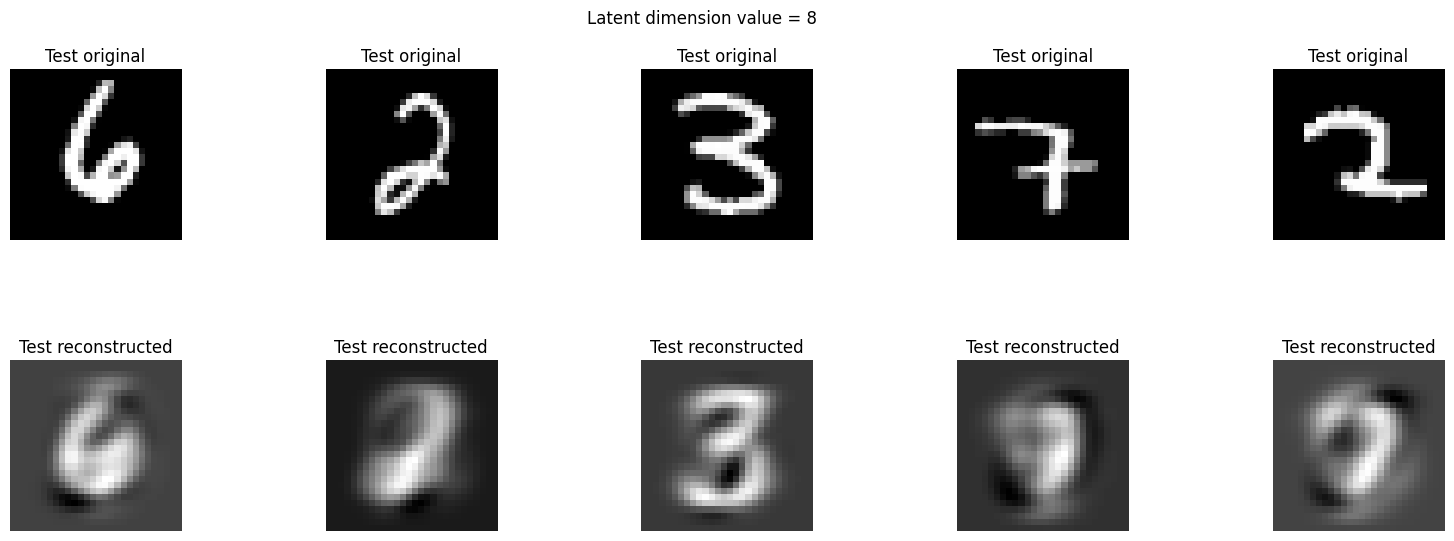

MSE val for latent dimension 16 is 0.02685230807925931


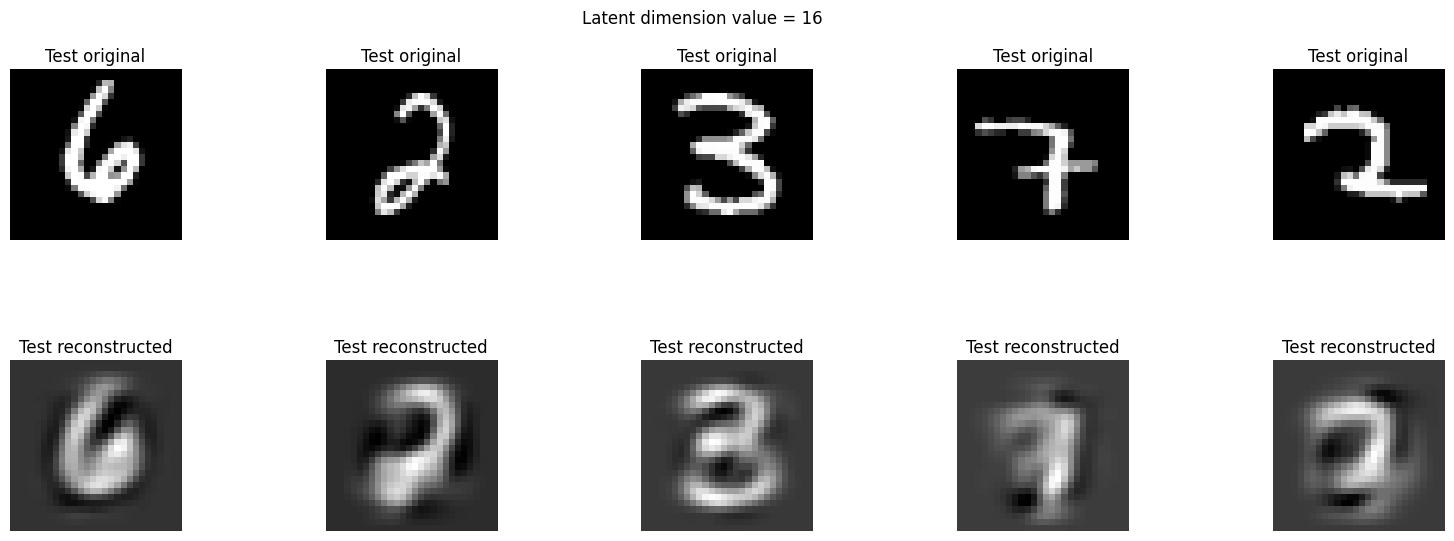

MSE val for latent dimension 32 is 0.01682450735610923


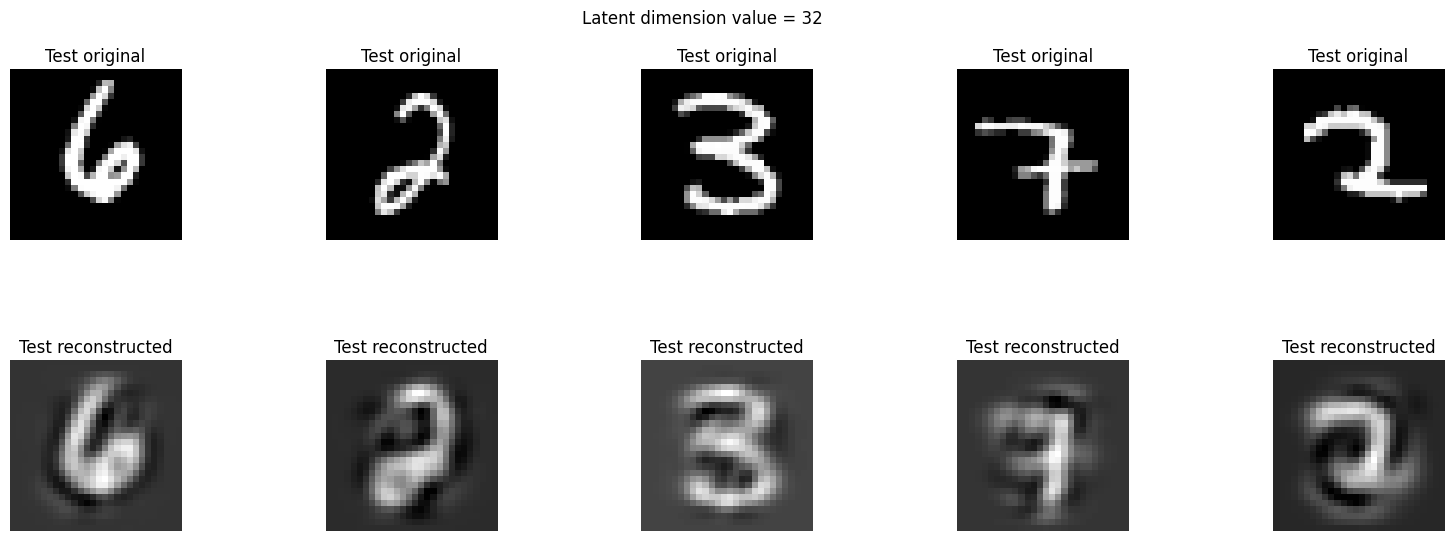

MSE val for latent dimension 64 is 0.009045238607576146


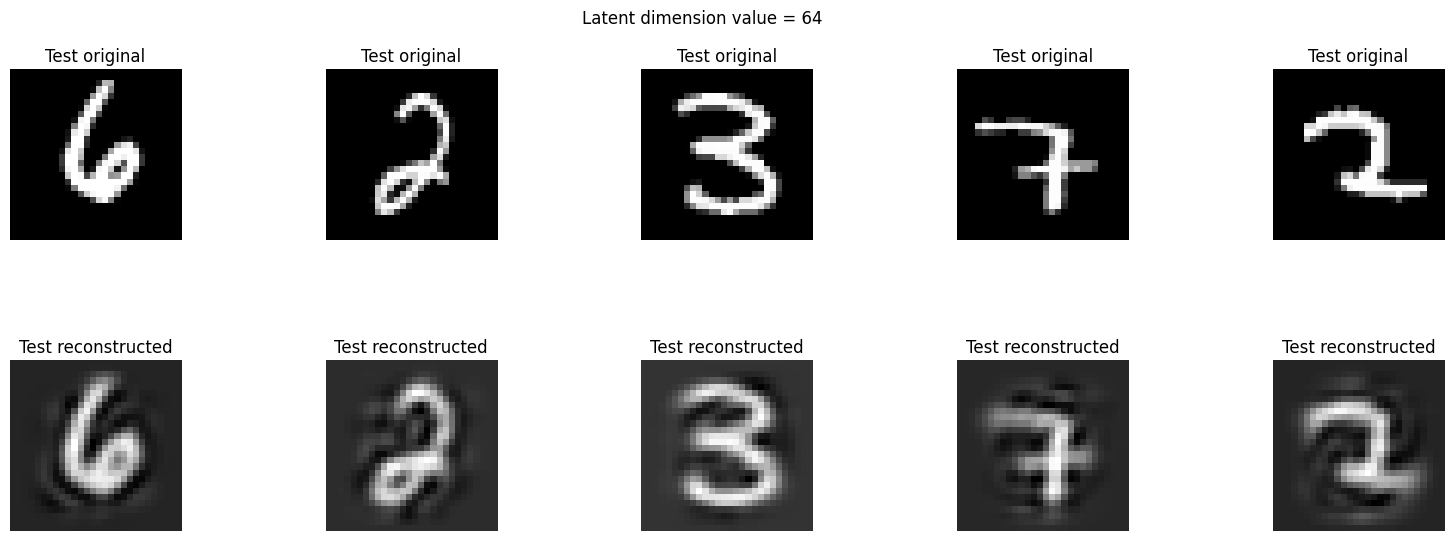

In [17]:
import matplotlib.pyplot as plt

latentDimensions = [2, 4, 8, 16, 32, 64]

def probabilisticPCA(centeredTrainImages, latentDimensionValue):
    '''numSamples = normalizedTrainImages.shape[0]
    trainMean = np.mean(normalizedTrainImages, axis = 0)
    covarianceMatrix = np.zeros((normalizedTrainImages.shape[1], normalizedTrainImages.shape[1]))
    imgCount = 0
    for image in normalizedTrainImages:
        imgCount = imgCount + 1
        print(imgCount)

        image = image.reshape(-1,1)
        covarianceMatrix += np.dot(image - trainMean, (image - trainMean.T))

    covarianceMatrix = covarianceMatrix / numSamples'''
    covarianceMatrix = (centeredTrainImages.T @ centeredTrainImages) / len(centeredTrainImages)

    #nan_indices = np.where(np.isnan(covarianceMatrix))
    #print("Indices with NaN in Covariance Matrix:", nan_indices)


    #print("Any NaN in Covariance Matrix:", np.any(np.isnan(covarianceMatrix)))       
    
    eigenValues, eigenVectors = np.linalg.eigh(covarianceMatrix)


    Um = eigenVectors[:, -latentDimensionValue:]    
    Lm = np.diag(eigenValues[-latentDimensionValue:])   #Diagonal matrix of eigenvalues

    I = np.eye(latentDimensionValue)
    sigmaSquare = (1 /  centeredTrainImages.shape[1] - latentDimensionValue) * np.sum(eigenValues[latentDimensionValue + 1:])
    R = I  # Since its arbitrary, we take R as an identity matrix
    
    weights = Um @ np.sqrt(abs(Lm - sigmaSquare * I)) @ R

    return weights

def imageReconstruction(testImages, weights, mean, sigma, latentDimensionValue):

    #Z, residuals, _, _ = np.linalg.lstsq(weights.T @ weights + 1e-5 * np.eye(weights.shape[1]), weights.T @ (normalizedImages - mean).T, rcond=None) 
    #print("Weights.T @ Weights:", weights.T @ weights)
    #print("Weights.T @ (normalizedImages - mean).T:", weights.T @ (normalizedImages - mean).T)

    #Z = np.linalg.solve((weights.T @ weights), (weights.T) @ (normalizedImages - mean).T) 
    #X = WZ + u
    #return (weights @ Z).T + mean

    M = weights.T @ weights + sigma**2 * np.eye(latentDimensionValue)

    z = (np.linalg.inv(M) @ weights.T @ (testImages).T)

    K = (weights @ (np.linalg.inv(weights.T @ weights)) @ M @ z).T
    x_pred = K + mean.reshape(-1,1).T
    return x_pred

trainMean = np.mean(flattenedTrainImages, axis = 0)
#standardDev = np.std(flattenedTrainImages, axis = 0)
#N = flattenedTrainImages.shape[0]
#D = flattenedTrainImages.shape[1]
sigma = np.std(flattenedTestImages)
testMean = np.mean(flattenedTestImages, axis = 0)

centeredTrainImages = flattenedTrainImages - trainMean
centeredTestImages = (flattenedTestImages - testMean)

ppca_mse_values_list = []

for latentDimensionValue in latentDimensions:

     
    weights = probabilisticPCA(centeredTrainImages, latentDimensionValue)
    reconstructedImages = imageReconstruction(centeredTestImages, weights, testMean, sigma, latentDimensionValue) 
    mseSum = 0

    plt.figure(figsize=(20,6))
    plt.suptitle(f"Latent dimension value = {latentDimensionValue}")
    #print(reconstructedImages.shape)
    
    for idx in range(len(centeredTestImages)):
        #print(normalizedTestImages[idx])
        #print(reconstructedImage)
        mseVal = np.mean((flattenedTestImages[idx] - reconstructedImages[idx])**2)
        mseSum += mseVal
        
    finalMse = (mseSum) / len(centeredTestImages)
    ppca_mse_values_list.append(finalMse)
    print("MSE val for latent dimension {} is {}".format(latentDimensionValue,finalMse))

    for i, idx in enumerate(selectedImages):
        plt.subplot(2, 5, i + 1)
        plt.imshow(flattenedTestImages[idx].reshape(28,28), cmap='gray')
        plt.title(f"Test original")
        plt.axis('off') #Removes x and y axis labels

        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructedImages[idx].reshape(28,28), cmap='gray')    #reshaping the 1d array back to 2d for accessing
        plt.title(f"Test reconstructed")
        plt.axis('off')

    plt.subplots_adjust(hspace=0.7, wspace=0.1)
    plt.show()

## VARIATIONAL AUTOENCODER

Epoch 1/10
600/600 [==============================] - 4s 6ms/step - loss: 184.0217 - val_loss: 167.2889
Epoch 2/10
600/600 [==============================] - 5s 8ms/step - loss: 163.5149 - val_loss: 159.8346
Epoch 3/10
600/600 [==============================] - 4s 6ms/step - loss: 156.6292 - val_loss: 154.2938
Epoch 4/10
600/600 [==============================] - 4s 6ms/step - loss: 152.5616 - val_loss: 151.3835
Epoch 5/10
600/600 [==============================] - 3s 6ms/step - loss: 149.9411 - val_loss: 148.9254
Epoch 6/10
600/600 [==============================] - 4s 7ms/step - loss: 147.6594 - val_loss: 148.0083
Epoch 7/10
600/600 [==============================] - 4s 6ms/step - loss: 145.8679 - val_loss: 145.6689
Epoch 8/10
600/600 [==============================] - 3s 5ms/step - loss: 144.4718 - val_loss: 144.6337
Epoch 9/10
600/600 [==============================] - 3s 5ms/step - loss: 143.4367 - val_loss: 143.0564
Epoch 10/10
313/313 [==============================] - 0s 642us/

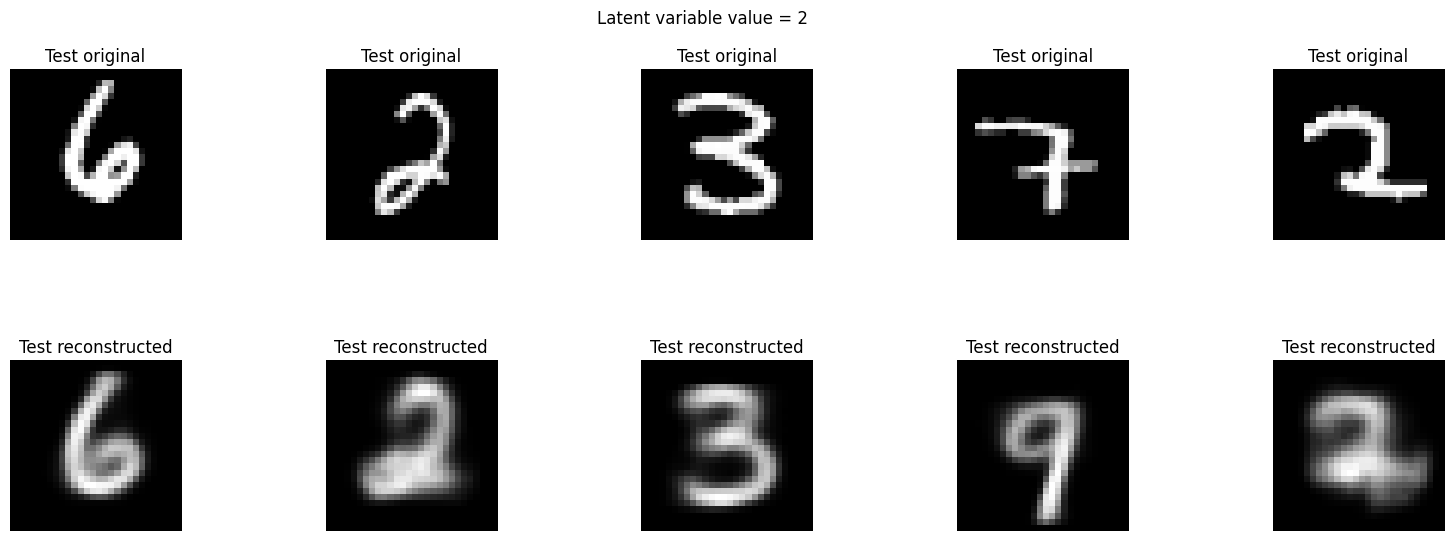

Epoch 1/10
600/600 [==============================] - 4s 5ms/step - loss: 170.3570 - val_loss: 145.8003
Epoch 2/10
600/600 [==============================] - 3s 5ms/step - loss: 140.4662 - val_loss: 135.0361
Epoch 3/10
600/600 [==============================] - 3s 5ms/step - loss: 133.4536 - val_loss: 131.3096
Epoch 4/10
600/600 [==============================] - 3s 5ms/step - loss: 129.7101 - val_loss: 127.7972
Epoch 5/10
600/600 [==============================] - 3s 5ms/step - loss: 127.2100 - val_loss: 126.0810
Epoch 6/10
600/600 [==============================] - 3s 5ms/step - loss: 125.4049 - val_loss: 124.4299
Epoch 7/10
600/600 [==============================] - 3s 5ms/step - loss: 124.0450 - val_loss: 123.7267
Epoch 8/10
600/600 [==============================] - 3s 5ms/step - loss: 122.9646 - val_loss: 122.8486
Epoch 9/10
600/600 [==============================] - 4s 6ms/step - loss: 122.0894 - val_loss: 122.1221
Epoch 10/10
313/313 [==============================] - 0s 694us/

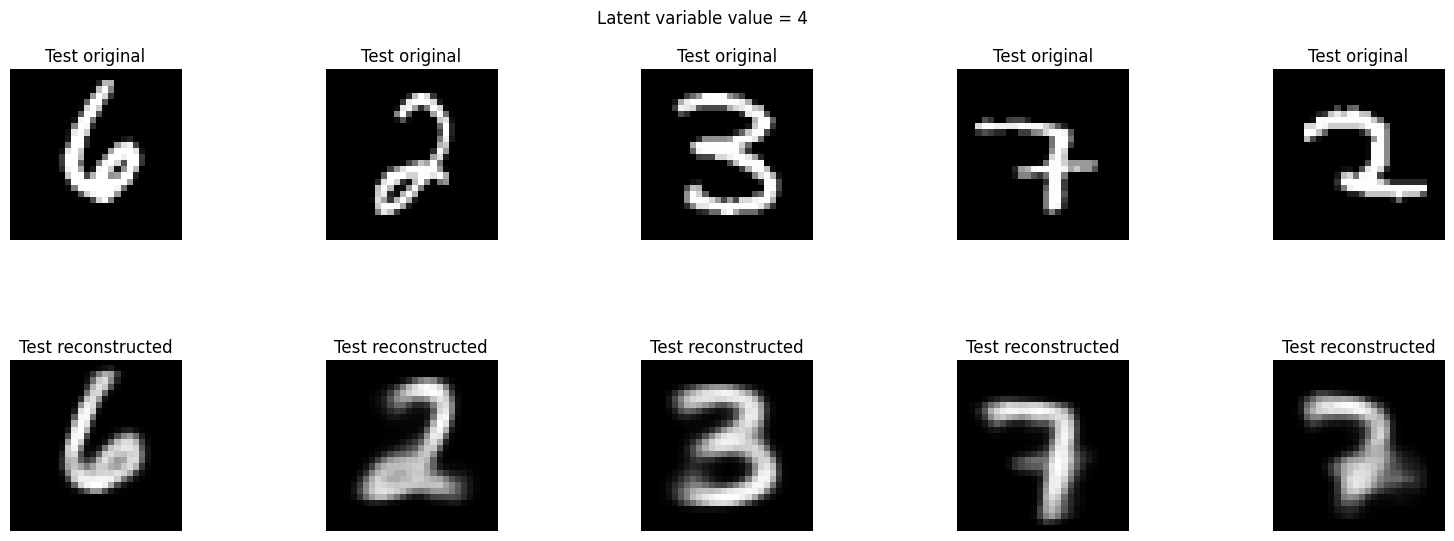

Epoch 1/10
600/600 [==============================] - 4s 5ms/step - loss: 267.6845 - val_loss: 133.3367
Epoch 2/10
600/600 [==============================] - 3s 5ms/step - loss: 126.1944 - val_loss: 119.4662
Epoch 3/10
600/600 [==============================] - 3s 5ms/step - loss: 116.9001 - val_loss: 112.7472
Epoch 4/10
600/600 [==============================] - 3s 6ms/step - loss: 112.5530 - val_loss: 110.3635
Epoch 5/10
600/600 [==============================] - 3s 6ms/step - loss: 109.7277 - val_loss: 107.2230
Epoch 6/10
600/600 [==============================] - 3s 5ms/step - loss: 107.7135 - val_loss: 106.4645
Epoch 7/10
600/600 [==============================] - 3s 5ms/step - loss: 106.1730 - val_loss: 104.8450
Epoch 8/10
600/600 [==============================] - 3s 5ms/step - loss: 104.9829 - val_loss: 104.0620
Epoch 9/10
600/600 [==============================] - 3s 5ms/step - loss: 104.0542 - val_loss: 103.4755
Epoch 10/10
313/313 [==============================] - 0s 638us/

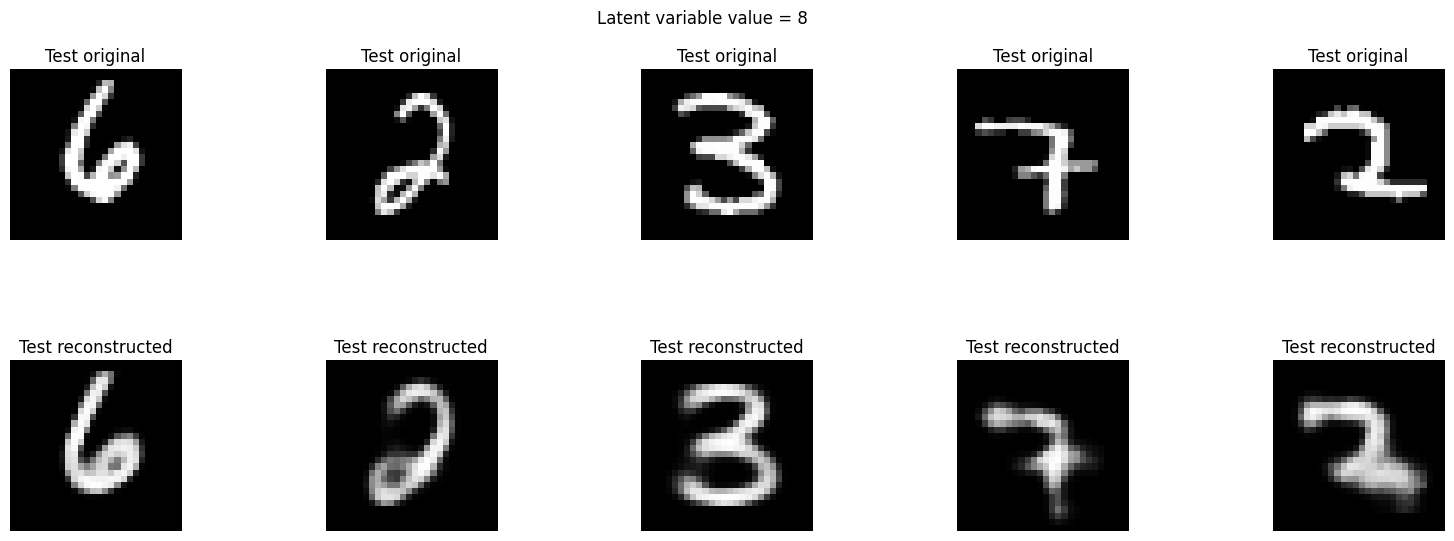

Epoch 1/10
600/600 [==============================] - 4s 5ms/step - loss: 164.4245 - val_loss: 131.2045
Epoch 2/10
600/600 [==============================] - 3s 6ms/step - loss: 123.2554 - val_loss: 115.7412
Epoch 3/10
600/600 [==============================] - 3s 5ms/step - loss: 112.3920 - val_loss: 107.7448
Epoch 4/10
600/600 [==============================] - 3s 5ms/step - loss: 106.7991 - val_loss: 104.0971
Epoch 5/10
600/600 [==============================] - 4s 7ms/step - loss: 103.4142 - val_loss: 101.2090
Epoch 6/10
600/600 [==============================] - 4s 7ms/step - loss: 101.1581 - val_loss: 99.3808
Epoch 7/10
600/600 [==============================] - 4s 6ms/step - loss: 99.5838 - val_loss: 100.0145
Epoch 8/10
600/600 [==============================] - 4s 6ms/step - loss: 98.3960 - val_loss: 96.9433
Epoch 9/10
600/600 [==============================] - 4s 6ms/step - loss: 97.4050 - val_loss: 96.8347
Epoch 10/10
313/313 [==============================] - 0s 708us/step
M

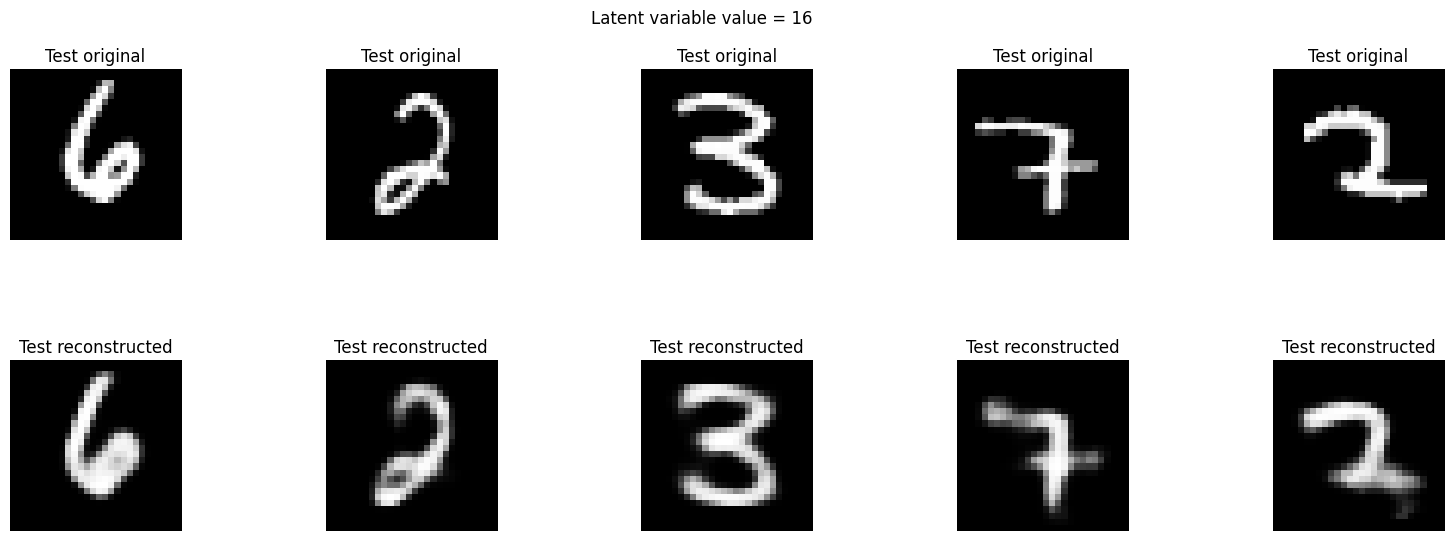

Epoch 1/10
600/600 [==============================] - 4s 6ms/step - loss: 162.5460 - val_loss: 133.5355
Epoch 2/10
600/600 [==============================] - 4s 6ms/step - loss: 125.2414 - val_loss: 116.6941
Epoch 3/10
600/600 [==============================] - 4s 7ms/step - loss: 114.2239 - val_loss: 109.9370
Epoch 4/10
600/600 [==============================] - 4s 6ms/step - loss: 108.4028 - val_loss: 106.1631
Epoch 5/10
600/600 [==============================] - 4s 6ms/step - loss: 104.5400 - val_loss: 101.2418
Epoch 6/10
600/600 [==============================] - 4s 6ms/step - loss: 101.9038 - val_loss: 101.4717
Epoch 7/10
600/600 [==============================] - 4s 6ms/step - loss: 99.9165 - val_loss: 100.7202
Epoch 8/10
600/600 [==============================] - 4s 6ms/step - loss: 98.5066 - val_loss: 97.5181
Epoch 9/10
600/600 [==============================] - 4s 6ms/step - loss: 97.3813 - val_loss: 95.9582
Epoch 10/10
313/313 [==============================] - 0s 694us/step


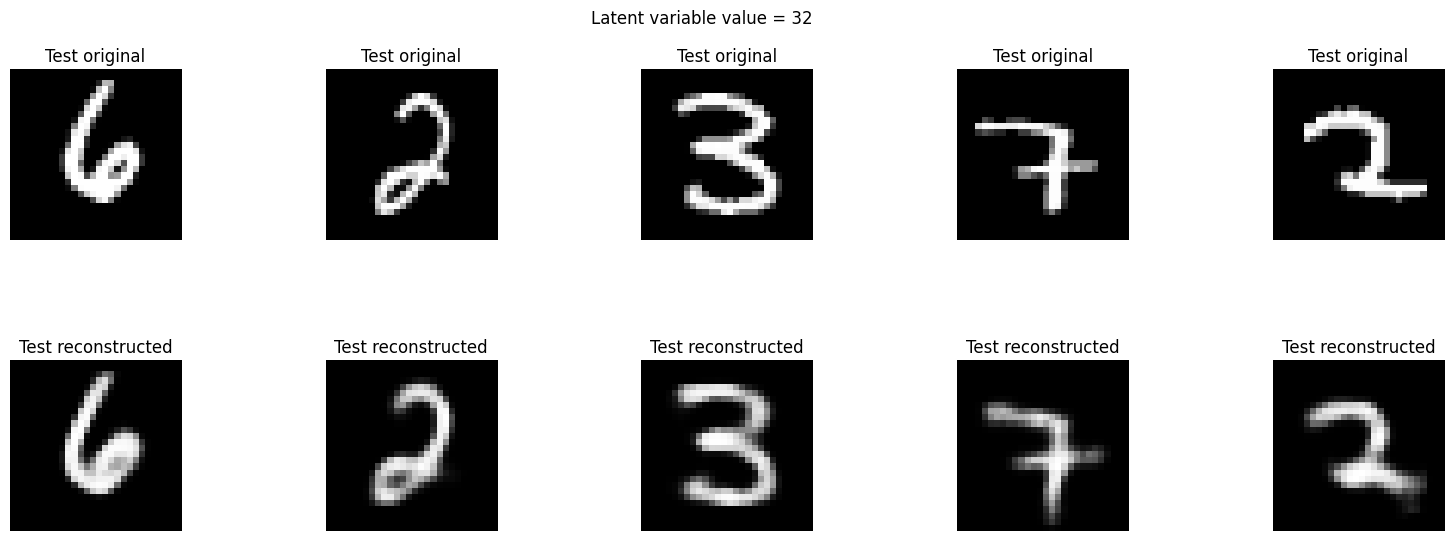

Epoch 1/10
600/600 [==============================] - 4s 6ms/step - loss: 167.4290 - val_loss: 137.2495
Epoch 2/10
600/600 [==============================] - 4s 6ms/step - loss: 130.6280 - val_loss: 122.1607
Epoch 3/10
600/600 [==============================] - 4s 6ms/step - loss: 117.9791 - val_loss: 114.1435
Epoch 4/10
600/600 [==============================] - 4s 6ms/step - loss: 110.6107 - val_loss: 107.7007
Epoch 5/10
600/600 [==============================] - 4s 6ms/step - loss: 106.0076 - val_loss: 102.9526
Epoch 6/10
600/600 [==============================] - 4s 6ms/step - loss: 102.9004 - val_loss: 100.9938
Epoch 7/10
600/600 [==============================] - 4s 7ms/step - loss: 100.7032 - val_loss: 98.6023
Epoch 8/10
600/600 [==============================] - 4s 6ms/step - loss: 98.9961 - val_loss: 97.6904
Epoch 9/10
600/600 [==============================] - 4s 6ms/step - loss: 97.6954 - val_loss: 96.8412
Epoch 10/10
313/313 [==============================] - 0s 691us/step


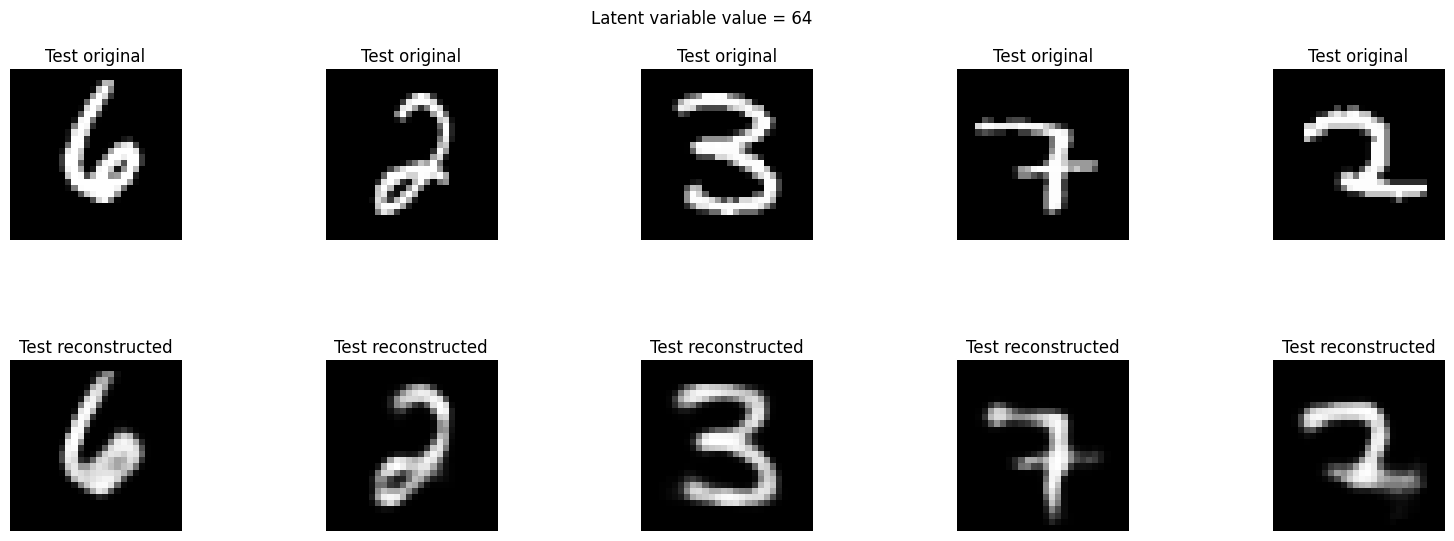

In [18]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K

latentDimensions = [2, 4, 8, 16, 32, 64]

batch_size, epoch = 100, 10
n_hidden = 256

def normalization(flattenedTrainImages):
    mean = np.mean(flattenedTrainImages, axis = 0)
    standardDev = np.std(flattenedTrainImages, axis = 0)

    #Handle 0 variance here, else NaN values are produced
    zeroVarianceIndices = np.where(standardDev == 0)[0]
    standardDev[zeroVarianceIndices] = 1e-5

    normalizedImages = (flattenedTrainImages - mean) / standardDev
    return normalizedImages, mean, standardDev

def variationalAutoEncoder(flattenedTrainImages, flattenedTestImages, latentDimensionValue):
    
    x = Input(shape=(flattenedTrainImages.shape[1:]))
    h1 = Dense(256, activation='relu')(x)
    h1 = Dense(128, activation='relu')(h1)

    mu = Dense(latentDimensionValue)(h1)
    log_var = Dense(latentDimensionValue)(h1)

    def sampling(args):
        mu, log_var = args
        eps = K.random_normal(shape=(batch_size, latentDimensionValue), mean=0., stddev=1.0)
        return mu + K.exp(log_var) * eps

    z = Lambda(sampling, output_shape=(latentDimensionValue,))([mu, log_var])

    z1 = Dense(128, activation='relu')
    z2 = Dense(256, activation='relu')
    y_decoder = Dense(flattenedTrainImages.shape[1], activation='sigmoid')

    h2 = z1(z)
    h2 = z2(h2)
    y = y_decoder(h2)

    kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
    reconstruction_loss = K.sum(K.binary_crossentropy(x, y), axis=-1)

    vae_loss = reconstruction_loss + kl_loss

    vae = Model(x, y)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')

    vae.fit(flattenedTrainImages,epochs=epoch,batch_size=batch_size,validation_data=(flattenedTestImages, None), verbose=1)

    encoder = Model(x, mu)
    z_latent = encoder.predict(flattenedTestImages, batch_size=batch_size)

    decoder_input = Input(shape=(latentDimensionValue,))
    h3 = z1(decoder_input)
    h3 = z2(h3)
    generatedImage = y_decoder(h3)
    generator = Model(decoder_input, generatedImage)

    reconstructed = generator.predict(z_latent)
    
    return reconstructed


normalizedTrainImages, mean, standardDev = normalization(flattenedTrainImages)
vae_mse_values_list = []

for latentDimensionValue in latentDimensions:

    normalizedTestImages = (flattenedTestImages - mean) / standardDev
    reconstructedImages = variationalAutoEncoder(flattenedTrainImages, flattenedTestImages, latentDimensionValue)
    mseVal = np.mean(np.square(flattenedTestImages - reconstructedImages))
    vae_mse_values_list.append(mseVal)
    
    print("MSE for latent dimension {} is: {}".format(latentDimensionValue,mseVal))

    plt.figure(figsize=(20,6))
    plt.suptitle(f"Latent variable value = {latentDimensionValue}")

    for i, idx in enumerate(selectedImages):
        plt.subplot(2, 5, i + 1)
        plt.imshow(testImages[idx], cmap='gray')
        plt.title(f"Test original")
        plt.axis('off') #Removes x and y axis labels

        plt.subplot(2, 5, i + 6)
        # reconstructed_image_np = reconstructedImages[idx].numpy()
        plt.imshow(reconstructedImages[idx].reshape(28,28), cmap='gray')
        plt.title(f"Test reconstructed")
        plt.axis('off')

    plt.subplots_adjust(hspace=0.7, wspace=0.1)
    plt.show()

COMPARATIVE STUDY

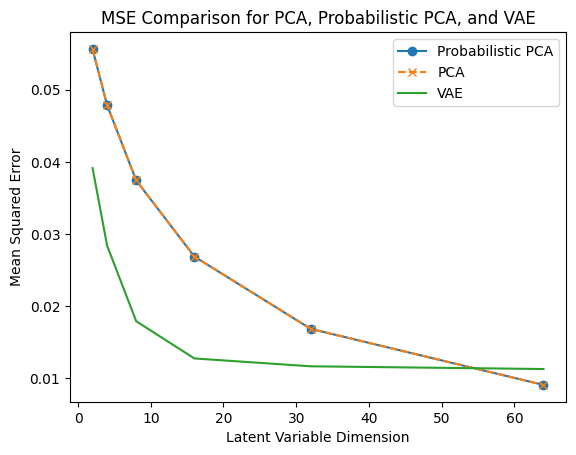

In [33]:
plt.plot(latentDimensions, ppca_mse_values_list, linestyle = '-', marker = 'o', label='Probabilistic PCA')
plt.plot(latentDimensions, pca_mse_values_list, linestyle = 'dashed', marker = 'x', label='PCA')
plt.plot(latentDimensions, vae_mse_values_list, label='VAE')
plt.xlabel('Latent Variable Dimension')
plt.ylabel('Mean Squared Error')
plt.title('MSE Comparison for PCA, Probabilistic PCA, and VAE')
plt.legend()
plt.show()